In [1]:
import numpy as np

def softmax(h):
    phat = np.exp(h)/((np.sum(np.exp(h),axis = 1)).reshape(len(h),1))
    return phat

def sigmoid(h):
    return (1/(1 + np.exp(-h)))

def crossEntropy(p,y):
    if y.shape[1] <= 1:
        return -np.sum(np.multiply(y,np.log(p))+np.multiply((1-y),np.log(1-p)))/len(p)
    else:
        return -np.sum(np.multiply(y,np.log(p)))/len(p)

def sumOfSquares(yhat, y):
    if y.shape[1] <= 1:
        return np.sum((y-yhat).T@(y-yhat))/len(yhat)
    else:
        return np.sum(np.trace((y-yhat).T.dot(y-yhat)))/len(yhat)

def drTanh(z):
    return(1-z**2)

def RELU(x):
    return x*(x>0)

def drRELU(x):
    return int(x>0)

def PRELU(x,p=1):
    return x*(x>0) + p*x*(x<=0)

def drPRELUa(x, p=1):
    return (x>0) + (x<=0)*p

def drPRELUp(x):
    return x*(x<=0)

In [2]:
class PRELUNeuralNetwork:
    
    def __init__(self, X, Y, nodes=[6,6,6], task='classification', customtask=None, customcost=None): 
        self.indims = np.array(X).shape[1]
        self.outdims = np.array(Y).shape[1]
        self.nodes = nodes
        self.nodes.append(self.outdims)
        self.layers = len(self.nodes)
        self.X = np.array(X)
        self.Y = np.array(Y)
        #for the activation function, tanh and RELU can be chosen by default
        self.activate = PRELU
        self.dr_activate = drPRELUa
        #Right now it can only take classification and regression, but it can accept custom inputs.
        if task == 'classification':
            if self.Y.shape[1] == 1:
                self.outputFunc = sigmoid
                self.costFunc = crossEntropy
            elif self.Y.shape[1] > 1:
                self.outputFunc = softmax
                self.costFunc = crossEntropy
            else:
                print("Invalid dimensions")
        elif task == 'regression':
            self.outputFunc = lambda x:x*1
            self.costFunc = sumOfSquares
        elif task == 'custom':
            self.outputFunc = customtask
            self.costFunc = customcost
        else:
            print("Invalid task input")
                
    def initializeWeights(self):
        self.W = {}
        self.B = {}
        self.P = {}
        self.W['0'] = np.random.randn(self.indims, self.nodes[0])
        self.B['0'] = np.random.randn(1, self.nodes[0])
        self.P['0'] = np.ones((1,self.nodes[0]))
        for i in range(1, self.layers):
            self.W[str(i)] = np.random.randn(self.nodes[i-1], self.nodes[i])
            self.B[str(i)] = np.random.randn(1, self.nodes[i])
        for i in range(1, self.layers-1):
            self.P[str(i)] = np.ones((1,self.nodes[i]))

            

    def initializeWeightsScaled(self):
        self.W = {}
        self.B = {}
        self.P = {}
        self.W['0'] = np.random.randn(self.indims, self.nodes[0]) * np.sqrt(2/(self.indims+self.nodes[0]))
        self.B['0'] = np.random.randn(1, self.nodes[0]) * np.sqrt(2/(self.indims+self.nodes[0]))
        self.P['0'] = np.ones((1,self.nodes[0]))
        for i in range(1, self.layers):
            self.W[str(i)] = np.random.randn(self.nodes[i-1], self.nodes[i]) * np.sqrt(2/(self.nodes[i-1]+self.nodes[i]))
            self.B[str(i)] = np.random.randn(1, self.nodes[i]) * np.sqrt(2/(self.nodes[i-1]+self.nodes[i]))
        for i in range(1,self.layers-1):
            self.P[str(i)] = np.ones((1,self.nodes[i]))
            
    def train(self, LR=1e-6, epochs=1000, vocal=False, split=.8, reinit=True, scaleweights=True):
        data_index = np.array(range(0,len(self.X)))
        np.random.shuffle(data_index)
        sp_i = int(np.floor(len(self.X)*split))
        trn_i = data_index[0:sp_i]
        val_i = data_index[sp_i:]
        train = np.take(self.X, trn_i, axis=0)
        ytrn = np.take(self.Y, trn_i, axis=0)
        val = np.take(self.X, val_i, axis=0)
        yval = np.take(self.Y, val_i, axis=0)
        self.Errors = []
        self.Z = {}
        self.D = {}
        err_best = np.inf
        if reinit == True:
            if scaleweights == True:
                self.initializeWeightsScaled()
            else:
                self.initializeWeights()
        for ep in range(epochs):
            #calculate Zs
            self.Z['0'] = self.activate(train@self.W['0']+self.B['0'], p=self.P['0'])
            for z in range(1,self.layers-1):
                self.Z[str(z)] = self.activate(self.Z[str(z-1)]@self.W[str(z)]+self.B[str(z)], p=self.P[str(z)])
            yhat = self.outputFunc(self.Z[str(self.layers-2)]@self.W[str(self.layers-1)]+self.B[str(self.layers-1)])
            #last Z is yhat
            self.D[str(self.layers-1)] = (yhat-ytrn)
            for d in range(2, self.layers+1):
                self.D[str(self.layers-d)] = (self.D[str(self.layers-d+1)]@self.W[str(self.layers-d+1)].T)*self.dr_activate(self.Z[str(self.layers-d)], p=self.P[str(self.layers-d)])
            #weight update
            self.P['0'] -= LR * np.sum((self.D['1']@self.W['1'].T) * drPRELUp(train@self.W['0']+self.B['0']), axis=0)
            for p in range(1,self.layers-1):
                self.P[str(p)] -= LR * np.sum((self.D[str(p+1)]@self.W[str(p+1)].T) * drPRELUp(self.Z[str(p-1)]@self.W[str(p)]+self.B[str(p)]),axis=0)
            self.W['0'] -= LR * train.T@self.D['0']
            for w in range(1, self.layers):
                self.W[str(w)] -= LR * self.Z[str(w-1)].T@self.D[str(w)]
                self.B[str(w)] -= LR * np.sum(self.D[str(w)], axis=0)
            #Validate
            self.Z['0'] = self.activate(val@self.W['0']+self.B['0'], p=self.P['0'])
            for z in range(1,self.layers-1):
                self.Z[str(z)] = self.activate(self.Z[str(z-1)]@self.W[str(z)]+self.B[str(z)], p=self.P[str(z)])
            yhat = self.outputFunc(self.Z[str(self.layers-2)]@self.W[str(self.layers-1)]+self.B[str(self.layers-1)])
            err = self.costFunc(yhat,yval)
            self.Errors.append(err)
            if vocal == True:
                print('Epoch: {} / Error: {}'.format(ep, err))
            if np.isnan(err) | np.isinf(err):
                if scaleweights == True:
                    self.initializeWeightsScaled()
                else:
                    self.initializeWeights()
                break
            if err < err_best:
                self.Wbest = self.W
                self.Bbest = self.B
                self.Pbest = self.P
                err_best = err
                                   
    def predict(self, test):
        self.Z = {}
        self.Z['0'] = self.activate(test@self.Wbest['0']+self.Bbest['0'], p=self.Pbest['0'])
        for i in range(1,self.layers-1):
            self.Z[str(i)] = self.activate(self.Z[str(i-1)]@self.Wbest[str(i)]+self.Bbest[str(i)], p=self.Pbest[str(i)])
        self.predictions=self.outputFunc(self.Z[str(self.layers-2)]@self.Wbest[str(self.layers-1)]+self.Bbest[str(self.layers-1)])

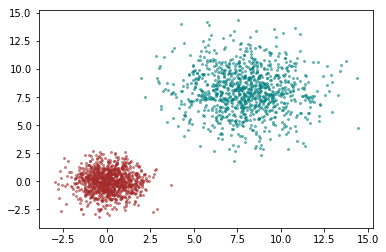

In [11]:
import matplotlib.pyplot as plt
#Min-max scaling
def normalizeMM(x,xtrn):
    newx = ((x - xtrn.min(0))/(xtrn.max(0)-xtrn.min(0)))
    return newx
N = 1000
x0 = np.random.randn(N,2)*2+8
lab0 = np.zeros((N,1))
x1 = np.random.randn(N,2)
lab1 = np.ones((N,1))
X = np.vstack((x0, x1))
X = normalizeMM(X,X)
Y = np.vstack((lab0,lab1))
plt.scatter(x0[:,0],x0[:,1], s=4, alpha=.5, c="teal")
plt.scatter(x1[:,0],x1[:,1], s=4, alpha=.5, c="brown")
plt.show()

In [12]:
NNpr = PRELUNeuralNetwork(X,Y, nodes=[6,6,6])

In [15]:
NNpr.train(epochs=10000, vocal=False)

In [16]:
NNpr.predict(X)
predicts = np.rint(NNpr.predictions)

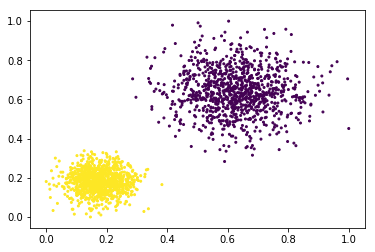

In [20]:
plt.scatter(X[:,0], X[:,1], s=4, c=predicts.reshape(2000,))
plt.show()